In [20]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Brochure Creation Tool using Imagen

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/vision/use-cases/broucher-creation-using-imagen/broucher-creation-using-imagen.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/vision/use-cases/broucher-creation-using-imagen/broucher-creation-using-imagen.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/vision/use-cases/broucher-creation-using-imagen/broucher-creation-using-imagen.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Sanchit Latawa](https://github.com/slatawa) , Divya Veerapandian

# Brochure Creation Tool using Imagen

A Generative AI driven tool utilizing Google Vertex AI and Imagen to create product Brochure material for promotional materials.


# Objectives
- Creating background images for Prodcut Brochures 
- Product Image would be placed on top of the background along with text like comapny name
- Should be able to add company logo image if provided




# Solution Architecture

![SOlution](./architecture.png) 

# Getting Started

# Install Vertex AI SDK & Other dependencies

In [21]:
!pip install opencv-python
!pip install rembg Pillow opencv-python numpy requests
!pip install gradio

Colab only: Run the following cell to restart the kernel. For Vertex AI Workbench you can restart the terminal using the button on top.

In [22]:
import sys

if "google.colab" in sys.modules:
    # Automatically restart kernel after installs so that your environment can access the new packages
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
else:
    # Otherwise, attempt to discover local credentials as described on https://cloud.google.com/docs/authentication/application-default-credentials
    pass

# Colab Only
You will need to run the following cell to authenticates your Colab environment with your Google Cloud account.

In [23]:
if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Import Required Libraries

In [24]:
import requests
import json
import base64
from io import BytesIO
import requests
import subprocess

import cv2
from PIL import Image as PIL_Image
from rembg import remove
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

import gradio as gr

# Env Variables

In [25]:
PROJECT_ID = "sl-test-project-353312"
REGION = "us-central1"

### Get token

In [26]:
# gcloud_token = !gcloud auth print-access-token
# gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
# print(gcloud_tokeninfo['email'])
# print(gcloud_token[0])
# ACCESS_TOKEN = gcloud_token[0]

### Sample Background prompts to choose from 

In [27]:
EXAMPLE_PROMPTS = [
    """Display a vibrant, high-resolution background illuminated by a combination of soft, diffused light and a touch of dramatic side lighting.The background consists of a clean, minimalist setting with subtle geometric patterns""",
    """Nature's Touch  Neutral beige background with a subtle gradient from a light brown to an off-white A faint, organic pattern of leaves and branches creates a natural and serene ambiance The pattern is intentionally blurred to prevent it from overpowering the product""",
    """Modern Simplicity Clean, white background with a soft gradient from a light blue to a pale gray Minimalistic lines form an abstract, geometric pattern in the background The pattern is subtle and fades into the background, allowing the product to take center stage""",
    """Neutral Paper with Faint Linen Texture  A neutral beige background resembling paper or canvas, providing a warm and inviting backdrop. A faint linen texture adds a touch of sophistication and depth, creating a subtle visual interest. The background conveys a sense of timeless elegance and quality, reflecting Company's commitment to craftsmanship and enduring products.""",
    """Soft Pastel Gradient with Organic Shapes  A soft gradient background transitioning between steel and blue, creating a sense of tranquility and optimism. Organic shapes, such as flowing lines or abstract curves, add a touch of movement and playfulness. The background evokes a sense of harmony, innovation, and a brighter future, embodying Company's dedication to societal advancement.""",
    """Light of the Future"*** **Minimalist Design:** Simple, flowing curves convey a sense of progress and fluidity.* **Subtle Gradient:** A subtle gradient from light blue to white creates a luminous backdrop, suggesting a bright future ahead.* **Neutral Colors:** Light blue and white provide a clean and airy neutral background.* **Subtle Pattern:** A faint geometric pattern of hexagons symbolizes technology and connectivity, reflecting Company's problem-solving nature.* **Company's Philosophy:** The flowing curves evoke a sense of optimism and a journey toward a brighter tomorrow.""",
]
FUTIRISTIC_EXAMPLE_PROMPTS = [
    """The background features a pristine, ultra-high-definition image of a CVD Coated Carbide surface. The surface is meticulously rendered with a high degree of precision, showcasing its smooth, lustrous finish.""",
    """A grid of abstract electronic circuit patterns in neon hues, forming a dynamic and futuristic backdrop""",
    """A seamless blend of organic and technological imagery against a matte gray background..""",
    """Crisp blue gradient background reminiscent of a clear night sky.""",
    """Subtle geometric shapes in soft blue and white, representing the harmony and fusion of technology and nature""",
    """Delicately sketched soft light blue and white circuit patterns interwoven into the gradient, resembling ethereal constellations""",
    """A shimmering, metallic horizon line at the base of the image, representing the intersection between cutting-edge technology and the boundless possibilities of the future.""",
    """A vast, white expanse stretching out to the horizon, with faint blue lines representing connectivity and growth.""",
    """Concept : Binary Landscape Image: A minimalist landscape composed of binary code that gradually morphs into intricate patterns. Color Palette: Blue and white, with subtle hints of gray to convey the contrast between technology and nature. Technical Specifications: 4K resolution, dynamic motion to symbolize the constant evolution of technology.""",
    """Concept : Problem-Solving Matrix Image: An abstract grid of interconnected nodes and lines. The grid represents a complex problem-solving space. Color Palette: White with accents of blue Futuristic Element: The grid is constantly shifting and adapting, symbolizing Company's iterative approach to problem-solving. Company's Philosophy: The image highlights Company's dedication to finding innovative solutions through meticulous analysis and collaboration.terconnected blue lines. Color Palette: Bright blue and white, emphasizing the idea of unity and collaboration. Technical Specifications: 4K resolution, close-up perspective for an intimate and impactful connection.""",
]

### Use this code to get possible prompt to genarate an Image background. Tune the prompt based on your idea

In [28]:
import vertexai
from vertexai.preview.generative_models import GenerativeModel, Part
import vertexai.preview.generative_models as generative_models


def generate_imagen_prompt_using_llm(temperature, colors, is_blurred, patterns, style):
    vertexai.init(project=PROJECT_ID, location=REGION)
    model = GenerativeModel("gemini-1.0-pro-001")

    add_blur_text = ""
    if is_blurred == "Yes":
        add_blur_text = "Blur the generate Image"

    llm_prompt = f"""Background: 
    As a distinguished marketing expert renowned for crafting captivating visuals, you excel in transforming intricate concepts into sleek, minimalist imagery tailored for brochures, PR materials, and sales collateral.Your expertise shines particularly bright in the electronics industry.
    Client: Company, a global technology trailblazer, epitomizes a profound dedication to leveraging technology for societal advancement. Their ethos underscores a commitment to shaping a better tomorrow through innovation and problem-solving. Company unveils a cutting-edge product and seeks your adept touch for a forward-thinking PR campaign. 
    
    Challenge: Your task is to conceive one background image concept that embody the following principles:
    Colors to be used: shades of {colors}
    Temperature: {temperature}
    Pattern to be used: {patterns}
    Style of the image: {style}
    Minimalist Design: Craft backgrounds with clean lines and simple shapes, eschewing clutter or intricate patterns that may divert attention from the product.
    Subtle Gradient: Infuse backgrounds with gentle gradients, seamlessly transitioning between hues to lend depth without overpowering the focal point. These gradients should evoke a sense of dimensionality, subtly enhancing the overall visual appeal.
    Subtle Texture or Pattern: Introduce faint patterns or subtle textures such as linen or paper to add visual interest without detracting from the product\'s prominence.
    Additionally, your designs should reflect Company\'s philosophy, embodying their commitment to a brighter future through technological innovation and problem-solving. 
    Ensure your backgrounds convey a sense of optimism, progress, and societal betterment.  Lastly, aim for high-quality, 4K resolution images to meet the client\'s expectations 
    for technical specifications. {add_blur_text}"""

    # Neutral Colors: Opt for soft gray, light blue, beige, or pastel tones to provide a neutral backdrop that accentuates the product without overshadowing it.
    responses = model.generate_content(
        llm_prompt,
        generation_config={"max_output_tokens": 2048, "temperature": 0.9, "top_p": 1},
        safety_settings={
            generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        },
        stream=True,
    )
    llm_image_prompts = []
    prompt_str = ""
    for response in responses:
        llm_image_prompt = response.text
        llm_image_prompts.append(llm_image_prompt)
    prompt_str = "".join(llm_image_prompts)
    return prompt_str

### Test Prompt creation using LLM for Imagen

In [29]:
temperature = "Cool"  ##  warm , cool ,neutral
colors = "white,blue"
is_blurred = "No"
patterns = "waves"
style = "Minimalistic"

prompt_for_imagen = generate_imagen_prompt_using_llm(
    temperature, colors, is_blurred, patterns, style
)
print(prompt_for_imagen)

[Image of a minimalist background with clean lines and simple shapes. The background is white with subtle shades of blue and waves. The waves are in a gentle gradient, which creates a sense of depth. The background has a subtle linen texture, which adds visual interest without detracting from the product's prominence. The overall effect is one of optimism, progress, and societal betterment.]

This background image concept embodies the following principles:

* **Colors to be used:** shades of white, blue
* **Temperature:** Cool
* **Pattern to be used:** waves
* **Style of the image:** Minimalistic
* **Minimalist Design:** The background has clean lines and simple shapes, eschewing clutter or intricate patterns that may divert attention from the product.
* **Subtle Gradient:** The background has a gentle gradient, seamlessly transitioning between hues to lend depth without overpowering the focal point. The gradient evokes a sense of dimensionality, subtly enhancing the overall visual app

## Methods required to Generate Image using Imagen API

In [30]:
from vertexai.preview.vision_models import ImageGenerationModel
import io


def imagen_generate_sdk(
    model_name: str,
    prompt: str,
    negativePrompt: str,
    sampleCount: int,
    seed=None,
    disablePersonFace=False,
    sampleImageStyle=None,
):
    model = ImageGenerationModel.from_pretrained(model_name)
    response = model.generate_images(
        prompt=prompt, number_of_images=sampleCount, negative_prompt=negativePrompt
    )

    pillow_images = []
    for image in response.images:
        image_bytes = io.BytesIO(image._image_bytes)  # Convert to in-memory file
        pillow_images.append(Image.open(image_bytes))
    return pillow_images


# Images should be an array of images in PIL image format
def display_images(pil_images):
    scale = 0.25
    sampleImageSize = 1536
    width = int(float(sampleImageSize) * scale)
    height = int(float(sampleImageSize) * scale)
    for index, result in enumerate(pil_images):
        width, height = pil_images[index].size
        print(index)
        display.display(
            pil_images[index].resize(
                (
                    int(pil_images[index].size[0] * scale),
                    int(pil_images[index].size[1] * scale),
                ),
                0,
            )
        )
        print()


def display_image(image):
    plt.imshow(image, cmap="gray")
    plt.axis("off")  # Turn off axes
    plt.show()

## Methods required to make Brochure

In [31]:
from PIL import Image, ImageColor, ImageFont, ImageDraw


def make_brochure(subject_image, bg_image, logo_image, banner_color):
    # subject_image = Image.open(subject_image_path) # load image
    # bg_image = Image.open(bg_image_path) # load image
    # logo_image = Image.open(logo_image_path) # load image

    # Call overlay to superimpose product image with background
    brochure_image = overlay(subject_image, bg_image, "middle right", None)

    # Define the size of the blue banners
    banner_height = 100  # Height of the banners in pixels
    # banner_color = (41,106,145)  # Teal Blue color for the banners
    banner_image = Image.new("RGB", (842, 100), banner_color)

    # Place the banner images on the top and bottom of the background image
    brochure_image.paste(banner_image, (0, 0))
    brochure_image.paste(banner_image, (0, brochure_image.height - banner_image.height))

    # Add Company Logo
    final_image = add_logo(brochure_image, logo_image, "top left", 0, banner_height)

    return final_image


def add_logo(image, logo, corner, padding, banner_height):
    """Adds the Company logo to one of the corners of an image."""
    # logo = remove(logo, alpha_matting = True,alpha_matting_foreground_threshold=40) # remove background
    logo = logo.resize(
        (int(image.width / 6), banner_height)
    )  ##(int(image.height * 0.1), int(image.height * 0.1)))
    logo = logo.convert("RGBA")
    if corner == "top left":
        image.paste(logo, (padding, padding), logo)
    elif corner == "top right":
        image.paste(logo, (image.width - logo.width - padding, padding), logo)
    elif corner == "bottom left":
        image.paste(logo, (padding, image.height - logo.height - padding), logo)
    elif corner == "bottom right":
        image.paste(
            logo,
            (image.width - logo.width - padding, image.height - logo.height - padding),
            logo,
        )
    return image


def overlay(subject_image, bg_img, position, bgColor):
    subject_image = subject_image.resize(
        tuple(int(ti / 4) for ti in subject_image.size)
    )
    subject_image_bg_removed = remove(
        subject_image, alpha_matting=True, bgcolor=bgColor
    )  # remove background
    ## in proportion to A4 size
    bg_img = bg_img.resize((842, 1191))

    if position == "top right":
        x = bg_img.width - subject_image_bg_removed.width
        y = 0
    elif position == "top center":
        x = (bg_img.width - subject_image_bg_removed.width) // 2
        y = 0
    elif position == "top left":
        x = 0
        y = 0
    elif position == "middle right":
        x = bg_img.width - subject_image_bg_removed.width - 30
        y = (bg_img.height - subject_image_bg_removed.height) // 2
    elif position == "center":
        x = (bg_img.width - subject_image_bg_removed.width) // 2
        y = (bg_img.height - subject_image_bg_removed.height) // 2
    elif position == "middle left":
        x = 30
        y = (bg_img.height - subject_image_bg_removed.height) // 2
    elif position == "bottom right":
        x = bg_img.width - subject_image_bg_removed.width
        y = bg_img.height - subject_image_bg_removed.height
    elif position == "bottom center":
        x = (bg_img.width - subject_image_bg_removed.width) // 2
        y = bg_img.height - subject_image_bg_removed.height
    elif position == "bottom left":
        x = 0
        y = bg_img.height - subject_image_bg_removed.height

    bg_img.paste(subject_image_bg_removed, (x, y), subject_image_bg_removed)
    return bg_img

## Wrapper call to instantiate required variables and call brochure generation 

In [32]:
import time
import random
import os


def call_brochure_maker(
    prompt, negative_prompt, logo_image, subject_image, banner_color, sampleResultCount
):
    IMAGE_MODEL_NAME = "imagegeneration@005"
    sampleCount = int(sampleResultCount)
    negativePrompt = "faces, people, animals, food, large objects"

    # Advanced option, try different the seed numbers any random integer number range: (0, 2147483647)
    seed = None
    sampleImageStyle = None

    images = imagen_generate_sdk(
        IMAGE_MODEL_NAME,
        prompt,
        negativePrompt,
        sampleCount,
        seed,
        False,
        sampleImageStyle,
    )
    # display_images(images)

    # Get the current timestamp, # Generate a random number # Concatenate timestamp and random number to create a unique number
    current_timestamp = int(time.time())
    random_number = random.randint(1000, 9999)
    unique_number = int(str(current_timestamp) + str(random_number))
    directory_path = "results/" + str(unique_number)
    if not os.path.exists(directory_path):
        # Create the directory
        os.makedirs(directory_path)

    results = []
    for bg_image in images:
        final_image = make_brochure(subject_image, bg_image, logo_image, banner_color)
        results.append(final_image)
    return results

### TEST - Call the Wrapper to call background genaration, add Banner, logo and create Brochure 

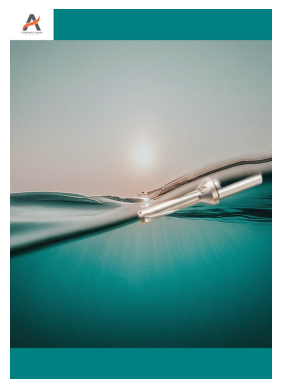

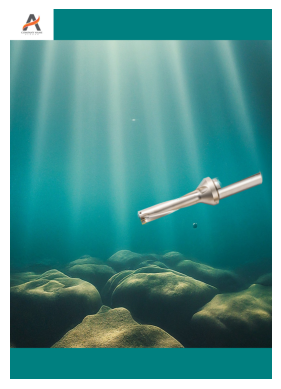

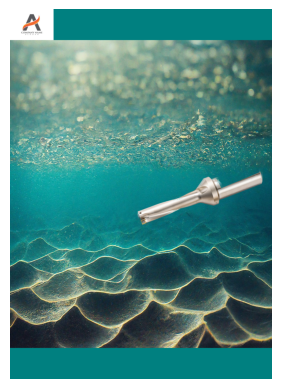

In [33]:
fg_path = "./S-DRV-4D.jpg"
logo_path = "./company_logo.jpeg"
banner_color = "teal"
subject_image = Image.open(fg_path)  # load image
logo_image = Image.open(logo_path)  # load image
sample_resultcount = 3
results = call_brochure_maker(
    "beautiful underwater image of sea in the background, subtle",
    "faces",
    logo_image,
    subject_image,
    banner_color,
    sample_resultcount,
)

for res in results:
    display_image(res)
    res.save("brochure.jpg")

### TEST - End to End Flow

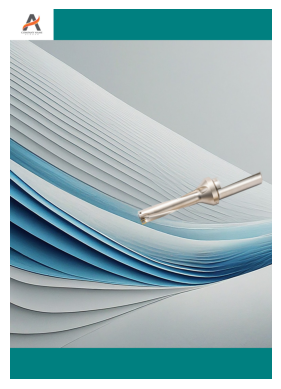

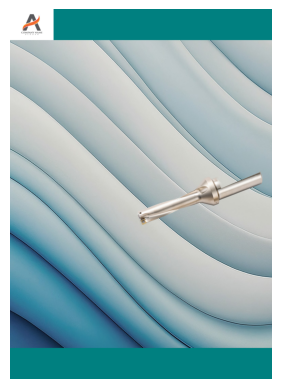

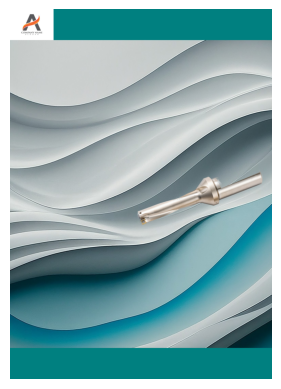

In [34]:
fg_path = "./S-DRV-4D.jpg"
logo_path = "./company_logo.jpeg"
banner_color = "teal"
subject_image = Image.open(fg_path)  # load image
logo_image = Image.open(logo_path)  # load image
sample_resultcount = 3


temperature = "Cool"  ##  warm , cool ,neutral
colors = "white,blue"
is_blurred = "No"
patterns = "waves"
style = "Minimalistic"

# generate Prompt
prompt_for_imagen = generate_imagen_prompt_using_llm(
    temperature, colors, is_blurred, patterns, style
)

# Generate Brochure
results = call_brochure_maker(
    prompt_for_imagen,
    "faces",
    logo_image,
    subject_image,
    banner_color,
    sample_resultcount,
)

for res in results:
    display_image(res)
    res.save("brochure.jpg")

### TEST - Call just the brochure maker with the background image of your choice to test 

# Sample UI App fro Demo

In [35]:
banner_color_options = [
    "aliceblue",
    "antiquewhite",
    "aqua",
    "aquamarine",
    "azure",
    "beige",
    "bisque",
    "black",
    "blanchedalmond",
    "blue",
    "blueviolet",
    "brown",
    "burlywood",
    "cadetblue",
    "chartreuse",
    "chocolate",
    "coral",
    "cornflowerblue",
    "cornsilk",
    "crimson",
    "cyan",
    "darkblue",
    "darkcyan",
    "darkgoldenrod",
    "darkgray",
    "darkgrey",
    "darkgreen",
    "darkkhaki",
    "darkmagenta",
    "darkolivegreen",
    "darkorange",
    "darkorchid",
    "darkred",
    "darksalmon",
    "darkseagreen",
    "darkslateblue",
    "darkslategray",
    "darkslategrey",
    "darkturquoise",
    "darkviolet",
    "deeppink",
    "deepskyblue",
    "dimgray",
    "dimgrey",
    "dodgerblue",
    "firebrick",
    "floralwhite",
    "forestgreen",
    "fuchsia",
    "gainsboro",
    "ghostwhite",
    "gold",
    "goldenrod",
    "gray",
    "grey",
    "green",
    "greenyellow",
    "honeydew",
    "hotpink",
    "indianred",
    "indigo",
    "ivory",
    "khaki",
    "lavender",
    "lavenderblush",
    "lawngreen",
    "lemonchiffon",
    "lightblue",
    "lightcoral",
    "lightcyan",
    "lightgoldenrodyellow",
    "lightgreen",
    "lightgray",
    "lightgrey",
    "lightpink",
    "lightsalmon",
    "lightseagreen",
    "lightskyblue",
    "lightslategray",
    "lightslategrey",
    "lightsteelblue",
    "lightyellow",
    "lime",
    "limegreen",
    "linen",
    "magenta",
    "maroon",
    "mediumaquamarine",
    "mediumblue",
    "mediumorchid",
    "mediumpurple",
    "mediumseagreen",
    "mediumslateblue",
    "mediumspringgreen",
    "mediumturquoise",
    "mediumvioletred",
    "midnightblue",
    "mintcream",
    "mistyrose",
    "moccasin",
    "navajowhite",
    "navy",
    "oldlace",
    "olive",
    "olivedrab",
    "orange",
    "orangered",
    "orchid",
    "palegoldenrod",
    "palegreen",
    "paleturquoise",
    "palevioletred",
    "papayawhip",
    "peachpuff",
    "peru",
    "pink",
    "plum",
    "powderblue",
    "purple",
    "red",
    "rosybrown",
    "royalblue",
    "saddlebrown",
    "salmon",
    "sandybrown",
    "seagreen",
    "seashell",
    "sienna",
    "silver",
    "skyblue",
    "slateblue",
    "slategray",
    "slategrey",
    "snow",
    "springgreen",
    "steelblue",
    "tan",
    "teal",
    "thistle",
    "tomato",
    "turquoise",
    "violet",
    "wheat",
    "white",
    "whitesmoke",
    "yellow",
    "yellowgreen",
]


def image_process_call_brochure_maker(
    background_context,
    negative_prompt,
    banner_color,
    logo_image,
    product_image,
    sample_resultcount,
):
    subject_image = PIL_Image.fromarray(product_image)
    logo_image_pil = PIL_Image.fromarray(logo_image)

    images_list_results = call_brochure_maker(
        background_context,
        negative_prompt,
        logo_image_pil,
        subject_image,
        banner_color,
        sample_resultcount,
    )
    return images_list_results


with gr.Blocks() as demo:
    with gr.Row():
        gr.Markdown("# Brochure Maker")
    with gr.Row():
        with gr.Column(min_width=100):
            gr.Markdown("## Prompt Generator")
            temperature = gr.Dropdown(
                choices=["Warm", "Cool", "Neutral"],
                label="Temperature",
                info="Color temperatureor light appearance on a cool to warm scale",
            )
            colors = gr.Textbox(
                label="Colors you want to see eg; white, blue or green, yellow"
            )
            patterns = gr.Textbox(
                label="Any patterns you want to see eg: lines, gemoremtric shapes, leaves, circles"
            )
            style = gr.Dropdown(
                choices=["Abstract", "Vintage", "Modern", "Minimalistic"], label="Style"
            )
            is_blurred = gr.Dropdown(choices=["Yes", "No"], label="Blurred ?")
            submit_button = gr.Button("Show Prompts")
            llm_image_prompts = gr.Textbox(label="Output Prompt(s)")
        with gr.Column(min_width=100):
            gr.Markdown("## Brochure Maker")
            with gr.Row():
                with gr.Column(min_width=100):
                    background_context = gr.Textbox(
                        label="Enter your prompt for image background"
                    )
                    negative_prompt = gr.Textbox(
                        label="Anything you want to avoid seeing in the image? eg: forest, plants, car"
                    )
                    banner_color = gr.Dropdown(
                        choices=banner_color_options,
                        label="Banner color",
                        info="Will appear on the top and bottom",
                    )
                    product_image = gr.Image(label="Product Image")
                    logo_image = gr.Image(label="Logo Image")
                    sample_resultcount = gr.Textbox(
                        label="How many images you want to see? 1-4"
                    )

            with gr.Row():
                with gr.Row():
                    with gr.Column(min_width=50):
                        generate_btn = gr.Button("Generate")
                    with gr.Column(min_width=50):
                        clear = gr.ClearButton()
    with gr.Row():
        with gr.Column():
            with gr.Column():
                with gr.Row():
                    bg_gallery = gr.Gallery()

    # clear.add([bg_gallery, background_context, negative_prompt, banner_color,logo_image, product_image])
    def on_click(
        background_context,
        negative_prompt,
        banner_color,
        logo_image,
        product_image,
        sample_resultcount,
    ):
        images_list = image_process_call_brochure_maker(
            background_context=background_context,
            negative_prompt=negative_prompt,
            banner_color=banner_color,
            logo_image=logo_image,
            product_image=product_image,
            sample_resultcount=sample_resultcount,
        )
        return gr.Gallery(images_list)

    generate_btn.click(
        fn=on_click,
        inputs=[
            background_context,
            negative_prompt,
            banner_color,
            logo_image,
            product_image,
            sample_resultcount,
        ],
        outputs=[bg_gallery],
    )

    submit_button.click(
        fn=generate_imagen_prompt_using_llm,
        inputs=[temperature, colors, is_blurred, patterns, style],
        outputs=[llm_image_prompts],
    )

demo.launch(debug=True, share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://f31be9bf30cabd61f0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f31be9bf30cabd61f0.gradio.live


# Conclusion

In this notebook we have successfully used GCP's GEN AI capabilities to generate background images and tie them together to generate a Product Brochure. Along with that we also created a sample UI to test the pipeline end to end.